In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

In [2]:
import os

BASE_PATH = '/gdrive/My Drive/CTF Deep Learning Workshop/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

# Tutorial on sparsification and regularization techniques

Deep learning models are prone to overfitting due to high model complexity. 

Overfitting can be combatted using regularization. Regularization generally means adding a constraint to your model, whether it be by enforcing sparsity or by adding a constraint term to your loss function. Regularization has the potential to improve model performance and generalizability, but like hyperparameter tuning, takes some time to get just right.

![picture](https://miro.medium.com/v2/0*seXiPgCCaHi19sJJ)

Source: https://www.researchgate.net/publication/332412613

Regularization is applied when training your model. Today, we're going to cover 4 different sparsification and regularization techniques. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

In [ ]:
def lorenz(Z, t, sigma, rho, beta):
    x, y, z = Z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = [1, 1, 1]
t = np.linspace(0, 100, 100000)
sol = odeint(lorenz, x0, t, args=(10, 28, 8/3))

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol[:,0], sol[:,1], sol[:,2], lw=0.5)
plt.show()


In [ ]:
# Build hankel matrix

delays = 100
sysdim = sol.shape[1]
dt = t[1] - t[0]

def build_hankel(x, delays):
    H = np.zeros((delays, len(x)-delays))
    for i in range(delays):
        H[i, :] = x[i: i+H.shape[1]]
    
    return H

measurements = sol[:, 0]
H = build_hankel(measurements, delays)
print('H_shape: ', H.shape)
print('dt : {}'.format(dt*delays))

We would like to find a mapping between the time delays $\mathbf{\hat{y}} = [x_i, x_{i+1}, \ldots, x_{i+n-1}]$ and the full state system $\mathbf z_i = [x_i, y_i, z_i]$

$$ \mathbf z = \mathbf f(\hat{\mathbf y}) $$

Can we approximate the function $\mathbf f$ by a neural network?

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Define model
class network(nn.Module):
    def __init__(self, input_dim=100, output_dim=3):
        super(network, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.l1 = nn.Linear(self.input_dim, 50)
        self.l2 = nn.Linear(50, 30)
        self.l3 = nn.Linear(30, 10)
        self.l4 = nn.Linear(10, self.output_dim)
    
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = F.elu(self.l2(x))
        x = F.elu(self.l3(x))
        x = self.l4(x)
        return x

### Prepare data

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

# Prepare data
X = H.T
y = sol[:X.shape[0], :]

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True)


# Turn numpy arrays into PyTorch Tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(x_train.shape)
print(x_test.shape)

trainset = TensorDataset(x_train, y_train)
testset = TensorDataset(x_test, y_test)

# Prepare data for training
bs = 30
trainset_dl = DataLoader(trainset, batch_size=bs, shuffle=False)
testset_dl = DataLoader(testset, batch_size=bs, shuffle=False)

In [ ]:
# Define training loop
def train_step(model, loss_fn, optim, trainset_dl):
    for xb, yb in trainset_dl:
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        loss.backward()
        optim.step()
        optim.zero_grad()
    return loss.item()

def test_step(model, loss_fn, optim, testset_dl):
    total_loss = 0
    batches = 0
    for xb, yb in testset_dl:
        batches += 1
        with torch.no_grad():
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
        total_loss += loss.item()
    return total_loss/batches

def fit(model, loss_fn, optim, trainset_dl, testset_dl, epochs=100):
    train_loss = []
    test_loss = []
    for i in range(epochs):
        train_loss.append(train_step(model, loss_fn, optim, trainset_dl))
        test_loss.append(test_step(model, loss_fn, optim, testset_dl))
        print('Epoch: {}, Train loss: {}, Test loss: {}'.format(i, train_loss[-1], test_loss[-1]))
    return train_loss, test_loss

loss_fn = nn.MSELoss()
model = network(delays, sysdim)
optim= torch.optim.Adam(model.parameters(), lr=1e-3)
train_loss, test_loss = fit(model, loss_fn, optim, trainset_dl, testset_dl, epochs=8)

In [ ]:
# plot train and test losses
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss, label='Train loss')
ax.plot(test_loss, label='Test loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
# Plot results

# Get predictions
with torch.no_grad():
    y_pred = model(torch.tensor(H.T, dtype=torch.float32))

# Plot predictions
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y_pred[:,0], y_pred[:,1], y_pred[:,2], lw=.5, label='Predictions')
ax.plot(y[:,0], y[:,1], y[:,2], lw=.5, label='True')
ax.legend()
plt.show()


# L2 and L1 Regularization

L2 and L1 regularization can be thought of simply as adding an extra contrstraint to your loss function. Specifically,  

*   L2 regularization encourages the parameter values of your model towards zero (but not exactly zero.) 
*   L1 regularization encourages the parameter values of your model **to be zero**

If the loss function is the mean-squared error, we simply add in the appropriate constraint function for our desired regularization method.

This can be visualized by the intersection the loss function makes with a constraint region as shown below. In L2 regularization (middle), the intersection between the constraint region (orange circle) and the loss function (contour lines).

**Some good resources:** 
*   An Introduction to Statistical Learning (book) by Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani
*   [Regularization in Deep Learning — L1, L2, and Dropout](https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036#:~:text=Regularization%20is%20a%20set%20of,data%20from%20the%20problem%20domain.) (Medium article) by Artem Oppermann



![picture](https://media.licdn.com/dms/image/C4D12AQEgtRRdCc0GTQ/article-cover_image-shrink_423_752/0/1558564555680?e=1681948800&v=beta&t=feDkzHp42LAMmVcUIMcuLGe8IjnwwPN5zmmiTICHsT0)

Source: [https://www.linkedin.com/pulse/regularization-episode-1-amr-mahmoud/](https://www.linkedin.com/pulse/regularization-episode-1-amr-mahmoud/)

## L2 Regularization

L2 regularization (or weight decay) is implemented in PyTorch using the **weight_decay** parameter while initializing the optimizer. Use a weight decay greater than zero. The weight decay parameter is a scalar value that scales the amount we regularize by the L2 norm. 

In [16]:
model_L2 = network(delays, sysdim) #There is nothing different in the model - just renamining it for clarity

In [17]:
# Define optimizer and loss function
optim_L2 = torch.optim.Adam(model_L2.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
train_loss, test_loss = fit(model_L2, loss_fn, optim_L2, trainset_dl, testset_dl, epochs=5)

## L1 Regularization

L1 regularization is implemented in PyTorch with the L1 loss function **torch.nn.L1Loss**. The Mean Absolute Error (MAE), also called L1 Loss, computes the average of the sum of absolute differences between actual values and predicted values.

PyTorch documentation: [https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)

In [20]:
model_L1 = network(delays, sysdim) #Again, there is nothing different in the model - just renamining it for clarity
optim_L1 = torch.optim.Adam(model_L1.parameters(), lr=1e-3)

In [21]:
loss_fn_L1 = nn.L1Loss()

In [ ]:
train_loss, test_loss = fit(model_L1, loss_fn_L1, optim_L1, trainset_dl, testset_dl, epochs=5)

## Dropout

Dropout is another powerful method for improving model performance in deep learning. Dropout is implemented during the training of a network. Nodes are randomly and temporarily made zero based on some probability, p. 

![picture](https://miro.medium.com/v2/format:webp/1*5t5lyeuTBLNV6Gl23cbZig.png)

Source: Journal of Machine Learning Research 15 (2014)


Dropout is implemented in PyTorch with dropout layers. The dropout layer has a parameter, p, which is the probability of an element to be made zero. The defualt is 0.5.

PyTorch documentation: [https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [23]:
# Define model
class dropoutnetwork(nn.Module):
    def __init__(self, input_dim=100, output_dim=3):
        super(dropoutnetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.l1 = nn.Linear(self.input_dim, 50)
        self.l2 = nn.Linear(50, 30)
        self.l3 = nn.Linear(30, 10)
        self.l4 = nn.Linear(10, self.output_dim)

        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = self.dropout(x)
        x = F.elu(self.l2(x))
        x = self.dropout(x)
        x = F.elu(self.l3(x))
        x = self.dropout(x)
        x = self.l4(x)
        return x

In [ ]:
dropoutmodel = dropoutnetwork(delays, sysdim)
print(dropoutmodel)

optim_do = torch.optim.Adam(dropoutmodel.parameters(), lr=1e-3)

From here, you can train this network using the training loop above.

In [ ]:
train_loss, test_loss = fit(dropoutmodel, loss_fn, optim_do, trainset_dl, testset_dl, epochs=5)

## Pruning

Neural network pruning can be used to increase model performance (via reducing model complexity) and make a model computationally more efficient.

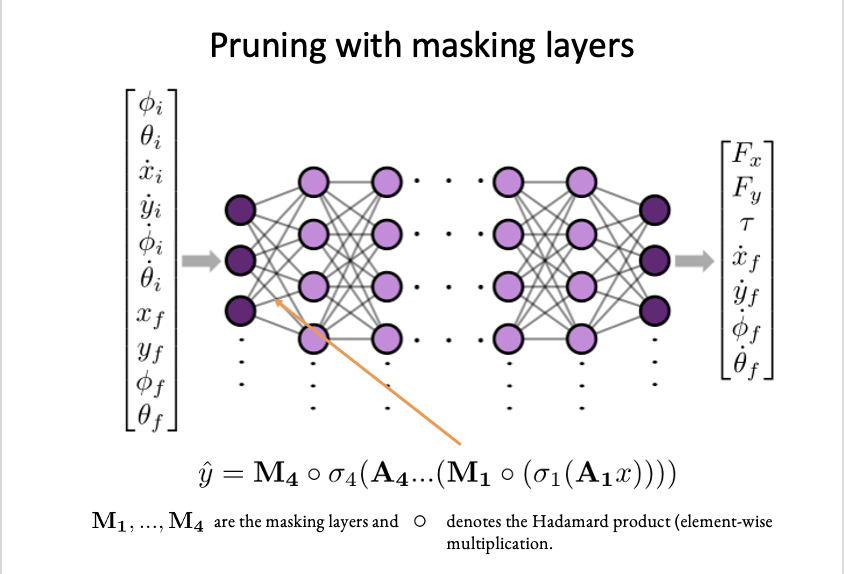

#### The basics

PyTorch has a built-in pruning library that allows you to implement many different types of pruning. 

PyTorch tutorial: [https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#global-pruning](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#global-pruning)

In [28]:
import torch.nn.utils.prune as prune

First let's look more closely at one of the layers in our original model (without dropout). The function

```
module.named_parameters()
```

will show us the parameters in a desired module, or layer, of our model.

In [ ]:
print(list(model.l2.named_parameters()))

We can also investigate the named buffers associated with this layer. Currently there are none, but this is where masking layers will be stored later.

In [ ]:
print(list(model.l2.named_buffers()))

We are now going to prune the weights of our module. We are going to use 

```
prune.random_unstructured
```
which prunes a layer gloabally, based on the magnitude of the parameter. The parameter **amount** is the percentage of the layer you want to prune. There are other options for pruning metrics which you can explore here: [PyTorch nn.utils](https://pytorch.org/docs/stable/nn.html#module-torch.nn.utils)




In [ ]:
prune.random_unstructured(model.l2, name="weight", amount=0.3)

If we list the named parameters again, we see that the parameter 'weight' has been replaced with 'weight_orig.' The parameter 'weight_orig' stores the unpruned weights of the layer. To see the mask, we need to investigate the named buffers. 

In [ ]:
print(list(model.l2.named_parameters()))

In [ ]:
print(list(model.l2.named_buffers()))

For a pruned module to be compatible with the forward pass, the 'weight' attribute is created. You can see that the 'weight' attribute store the weights multiplied by the mask. 

In [ ]:
print(model.l2.weight)

Additionally, for each layer we prune, a **forward_pre_hook** is created to enable the forward pass. We only have one so far, since we've only pruned one layer. 

In [ ]:
print(model.l2._forward_pre_hooks)

Let's now train our model with the pruned layer. We can use our original pruning loop that we defined above. 

In [ ]:
train_loss, test_loss = fit(model, loss_fn, optim, trainset_dl, testset_dl, epochs=5)

If we investigate our **named_parameters**, **named_buffers**, and **weight** attribute, we can see that the pruning is sustained through forward and backpropagation. 

In [ ]:
print(list(model.l2.named_parameters()))

In [ ]:
print(list(model.l2.named_buffers()))

In [ ]:
print(model.l2.weight)

#### Global Pruning

There may be situations where you want to prune an entire model rather than individual layers. We can accomplish that with global pruning. 

In [40]:
model2 = network()

parameters_to_prune = (
    (model2.l1, 'weight'),
    (model2.l2, 'weight'),
    (model2.l3, 'weight'),
    (model2.l4, 'weight'),

    (model2.l1, 'bias'),
    (model2.l2, 'bias'),
    (model2.l3, 'bias'),
    
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.RandomUnstructured,
    amount=0.2,
)

In [ ]:
print(
    "Weight sparsity in l1.weight: {:.2f}%".format(
        100. * float(torch.sum(model2.l1.weight == 0))
        / float(model2.l1.weight.nelement())
    )
)
print(
    "Weight sparsity in l2.weight: {:.2f}%".format(
        100. * float(torch.sum(model2.l2.weight == 0))
        / float(model2.l2.weight.nelement())
    )
)
print(
    "Weight sparsity in l3.weight: {:.2f}%".format(
        100. * float(torch.sum(model2.l3.weight == 0))
        / float(model2.l3.weight.nelement())
    )
)
print(
    "Weight sparsity in l4.weight: {:.2f}%".format(
        100. * float(torch.sum(model2.l4.weight == 0))
        / float(model2.l4.weight.nelement())
    )
)

print(
    "Bias sparsity in l1.bias: {:.2f}%".format(
        100. * float(torch.sum(model2.l1.bias == 0))
        / float(model2.l1.bias.nelement())
    )
)
print(
    "Bias sparsity in l2.bias: {:.2f}%".format(
        100. * float(torch.sum(model2.l2.bias == 0))
        / float(model2.l2.bias.nelement())
    )
)
print(
    "Bias sparsity in l3.bias: {:.2f}%".format(
        100. * float(torch.sum(model2.l3.bias == 0))
        / float(model2.l3.bias.nelement())
    )
)


print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model2.l1.weight == 0)
            + torch.sum(model2.l2.weight == 0)
            + torch.sum(model2.l3.weight == 0)
            + torch.sum(model2.l4.weight == 0)
            + torch.sum(model2.l1.bias == 0)
            + torch.sum(model2.l2.bias == 0)
            + torch.sum(model2.l3.bias == 0)
        )
        / float(
            model2.l1.weight.nelement()
            + model2.l2.weight.nelement()
            + model2.l3.weight.nelement()
            + model2.l4.weight.nelement()
            + model2.l1.bias.nelement()
            + model2.l2.bias.nelement()
            + model2.l3.bias.nelement()
        )
    )
)

# Your turn to practice what you've learned today! 

Feel free to use this notebook or another one you used today to practice building a network to model a dynamical system and use some regularization and sparsification techniques to improve performance. 

We have several datasets for you guys to work with: 


1.   Lorenz
2.   Sea-surface temperature data 
3.   Flow around a cylinder

We can help you access any of them. 

To get you stared, we've provided a [notebook](https://github.com/dynamicslab/ctf-dl-tutorial/blob/main/lorenz_diffeomorphism_practice.ipynb) for you to practice building an autoencoder network. This notebook has blank sections for you to fill in yourself. A notebook with the "answers" filled in can be found [here](https://github.com/dynamicslab/ctf-dl-tutorial/blob/main/lorenz_diffeomorphism.ipynb). 

Feel free to experiment with different regularization and sparsification techniques. 



# Questions (on sparsification and regularization)



1.   Using the network above (generic, feed-forward) can you use neural network pruning to create the sparsest, best-performing network you can for modeling the Lorenz system? Use any type of pruning method you'd like. Hint: retraining the network after pruning can improve performance. 
2.   When implementing L2 regularization, which value of weight decay works best for you? Can you **think** (don't implement) of a way to find the optimal weight decay parameter? 
3.   When implementing dropout, which p value works best for you?
4.   How sparse of a model do you get when implementing L1 regularization? Does your sparsest pruned model perform better? 

